In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize  # Use regular Normalize instead of TwoSlopeNorm

In [5]:
# Improve plots with line thickness, dpi, fontsize, etc.
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14



In [3]:
# Read in ground truth held suarez data
hs_ground_truth_filepath = "HS_ground_truth.cam.h1i.0001-01-01-10800.nc"

hs_ground_truth_nc = xr.open_dataset(hs_ground_truth_filepath)

# Average over longitude and vertical level
hs_ground_truth = hs_ground_truth_nc.T.mean(dim="lon").mean(dim="lev")

In [19]:
hs_ground_truth_nc

<xarray.Dataset>
Dimensions:       (lat: 64, lon: 128, lev: 30, ilev: 31, time: 3208, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lev           (lev) float64 16.67 50.0 83.33 116.7 ... 916.7 950.0 983.3
  * ilev          (ilev) float64 0.01 33.33 66.67 100.0 ... 933.3 966.7 1e+03
  * time          (time) object 0001-01-01 03:00:00 ... 0002-02-06 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/31)
    ntrk          int32 ...
    ntrn          int32 ...
    ntrm          int32 ...
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    ...            ...
    f12vmr        (time) float64 ...
    sol_tsi       (time) float64 ...
    nsteph        (time) int32 ...
    T             (time, lev, lat, lon) float32 249.8 249.8 ... 262.0 262.0
    U             (time, lev, lat, lon) float32 ...
    V             (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              HS_ground_truth
    logname:           teopb
    host:              derecho4
    initial_file:      /glade/campaign/cesm/cesmdata/inputdata/atm/cam/inic/g...
    topography_file:   bnd_topo
    model_doi_url:     not_set
    time_period_freq:  hour_3

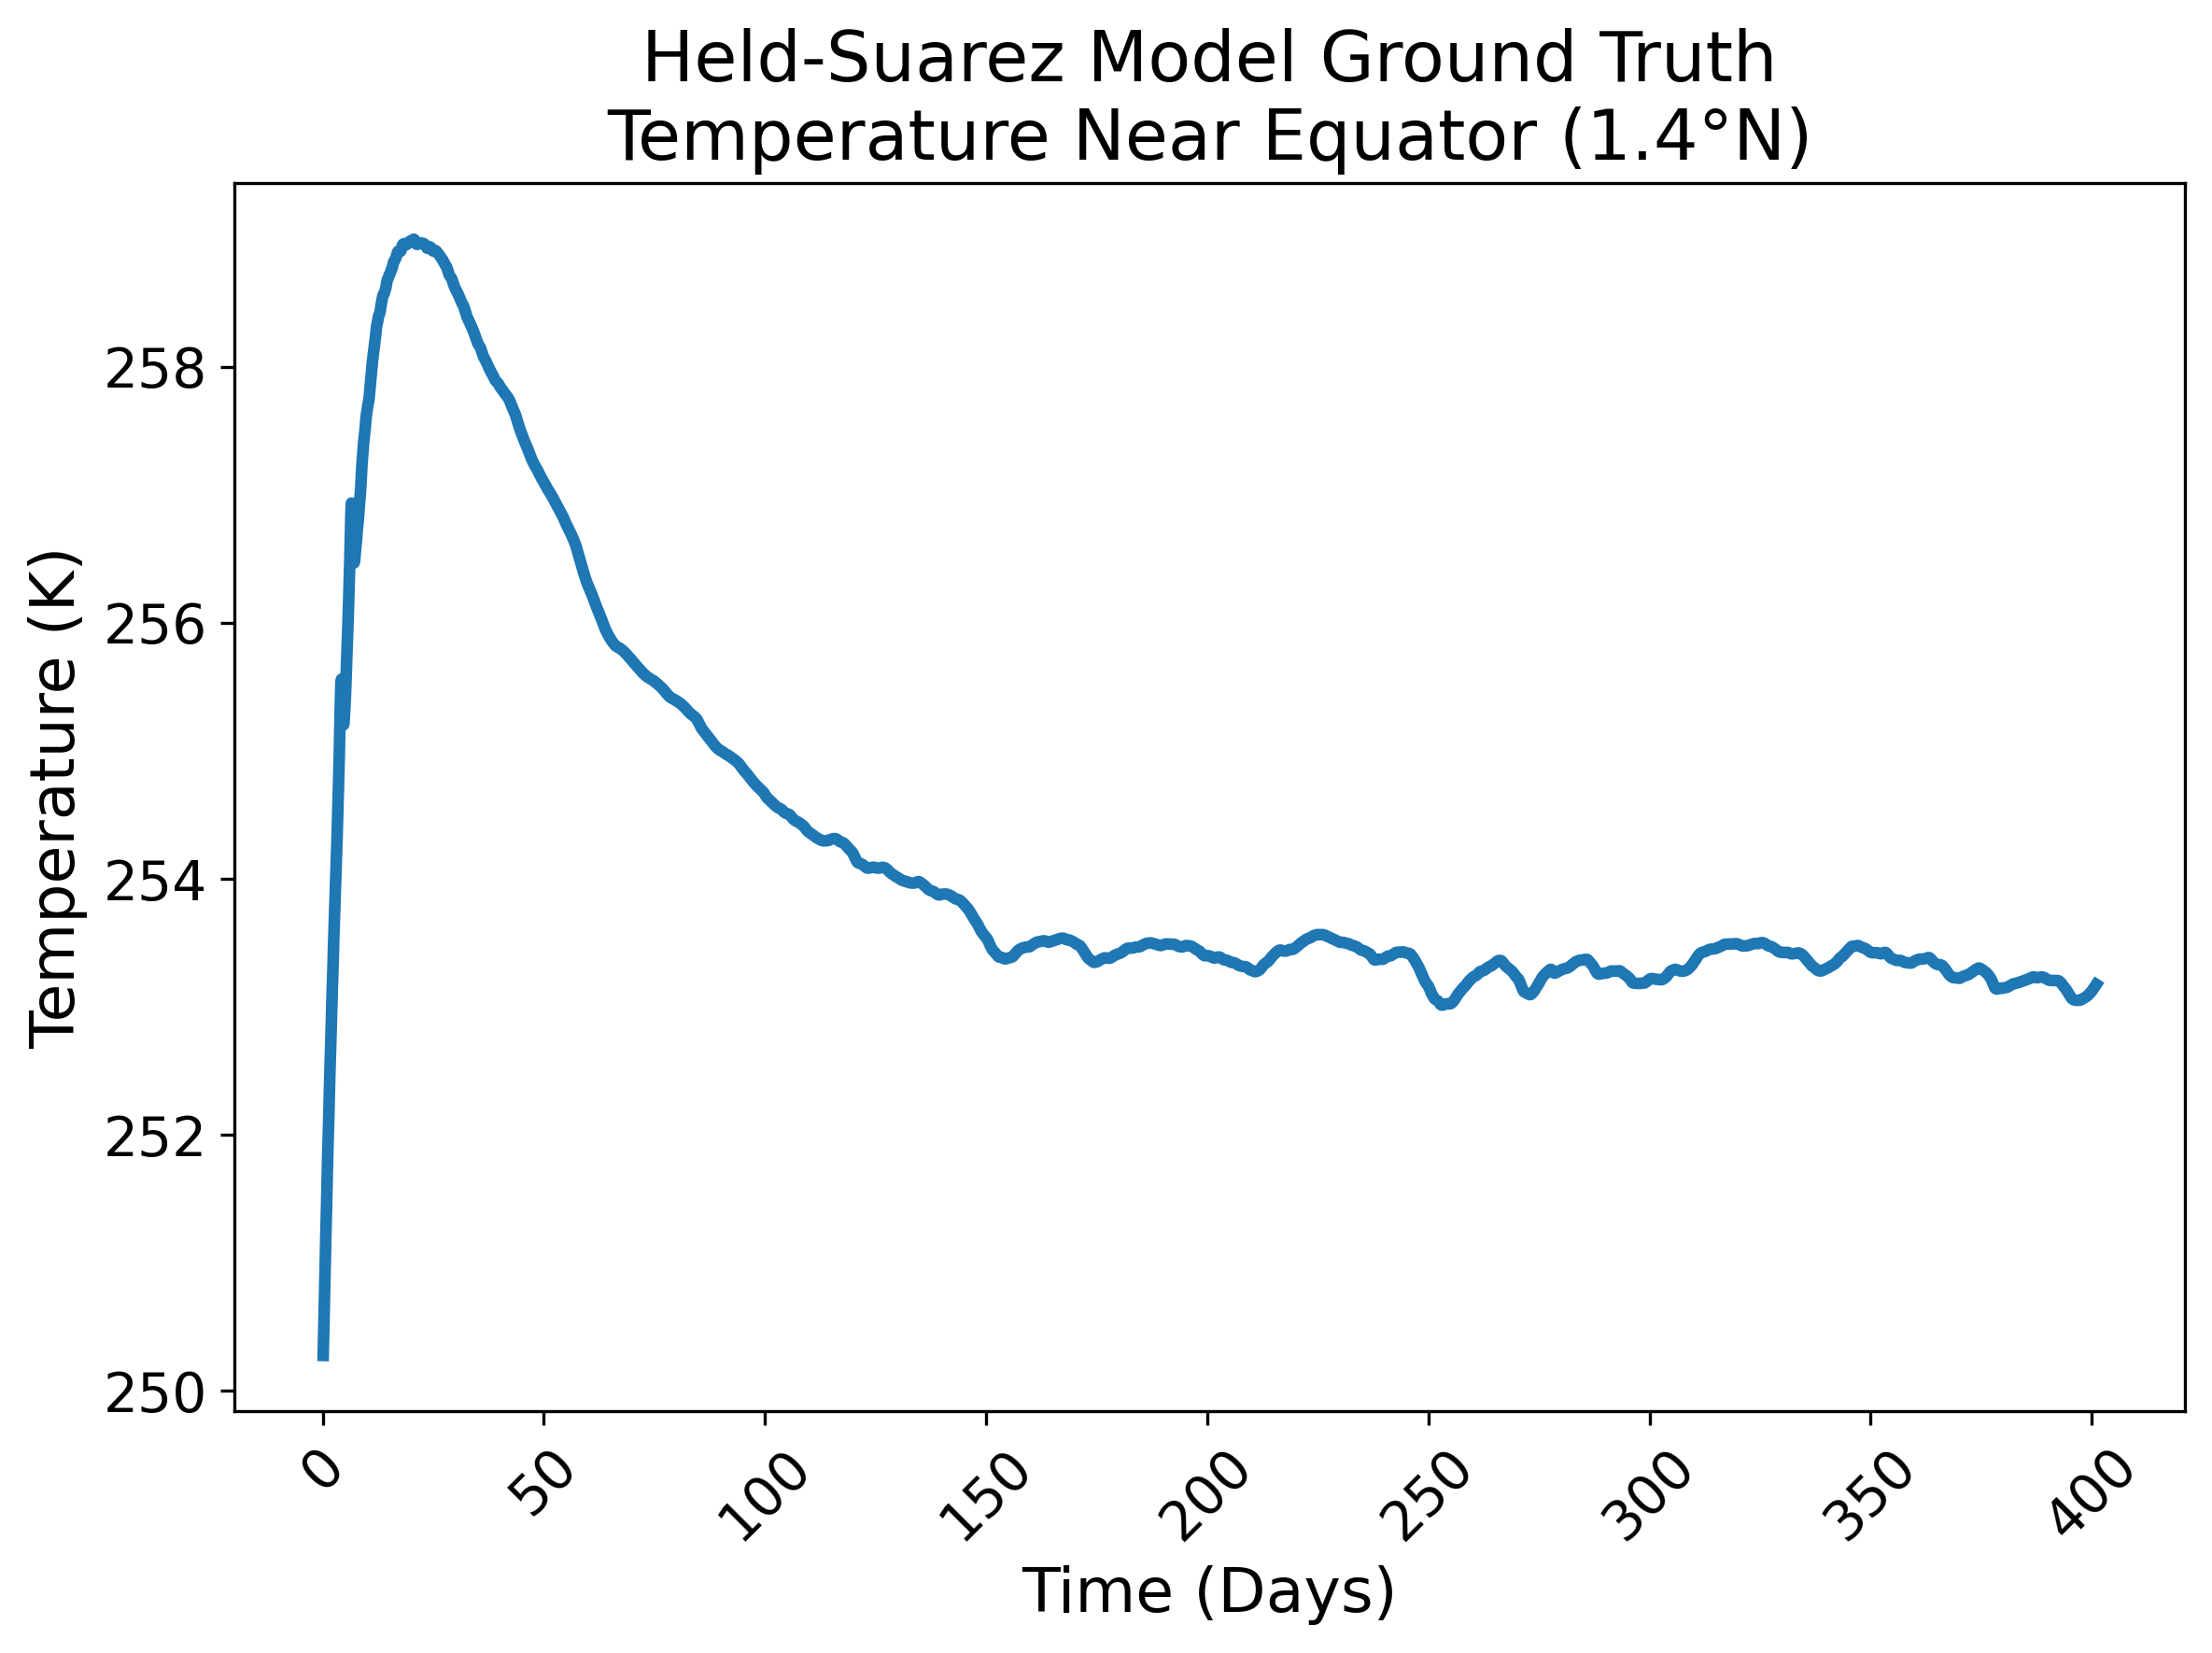

In [8]:
# Plot trajectory of middle latitude using seaborn

# Plot using seaborn
# create a time index the length of the dataset
# starting at 3 hours and incrementing by 3 hours in units of days
time_index = np.arange(1, len(hs_ground_truth) + 1, 1) * 3 / 24

# plot the temperature data
sns.lineplot(x=time_index, y=hs_ground_truth[:, 32])

plt.xlabel("Time (Days)")
plt.ylabel("Temperature (K)")
plt.title("Held-Suarez Model Ground Truth\nTemperature Near Equator (1.4°N)")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()       # Adjust layout to prevent label cutoff

plt.savefig("HS_GT_equator_lat_evolution.png", dpi=300)

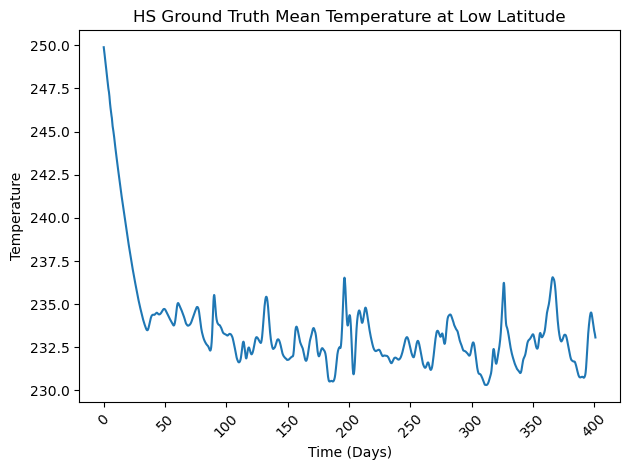

In [17]:
# Plot trajectory of upper latitude using seaborn

# plot the temperature data
sns.lineplot(x=time_index, y=hs_ground_truth[:, 0])

plt.xlabel("Time (Days)")
plt.ylabel("Temperature")
plt.title("HS Ground Truth Mean Temperature at Low Latitude")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()       # Adjust layout to prevent label cutoff

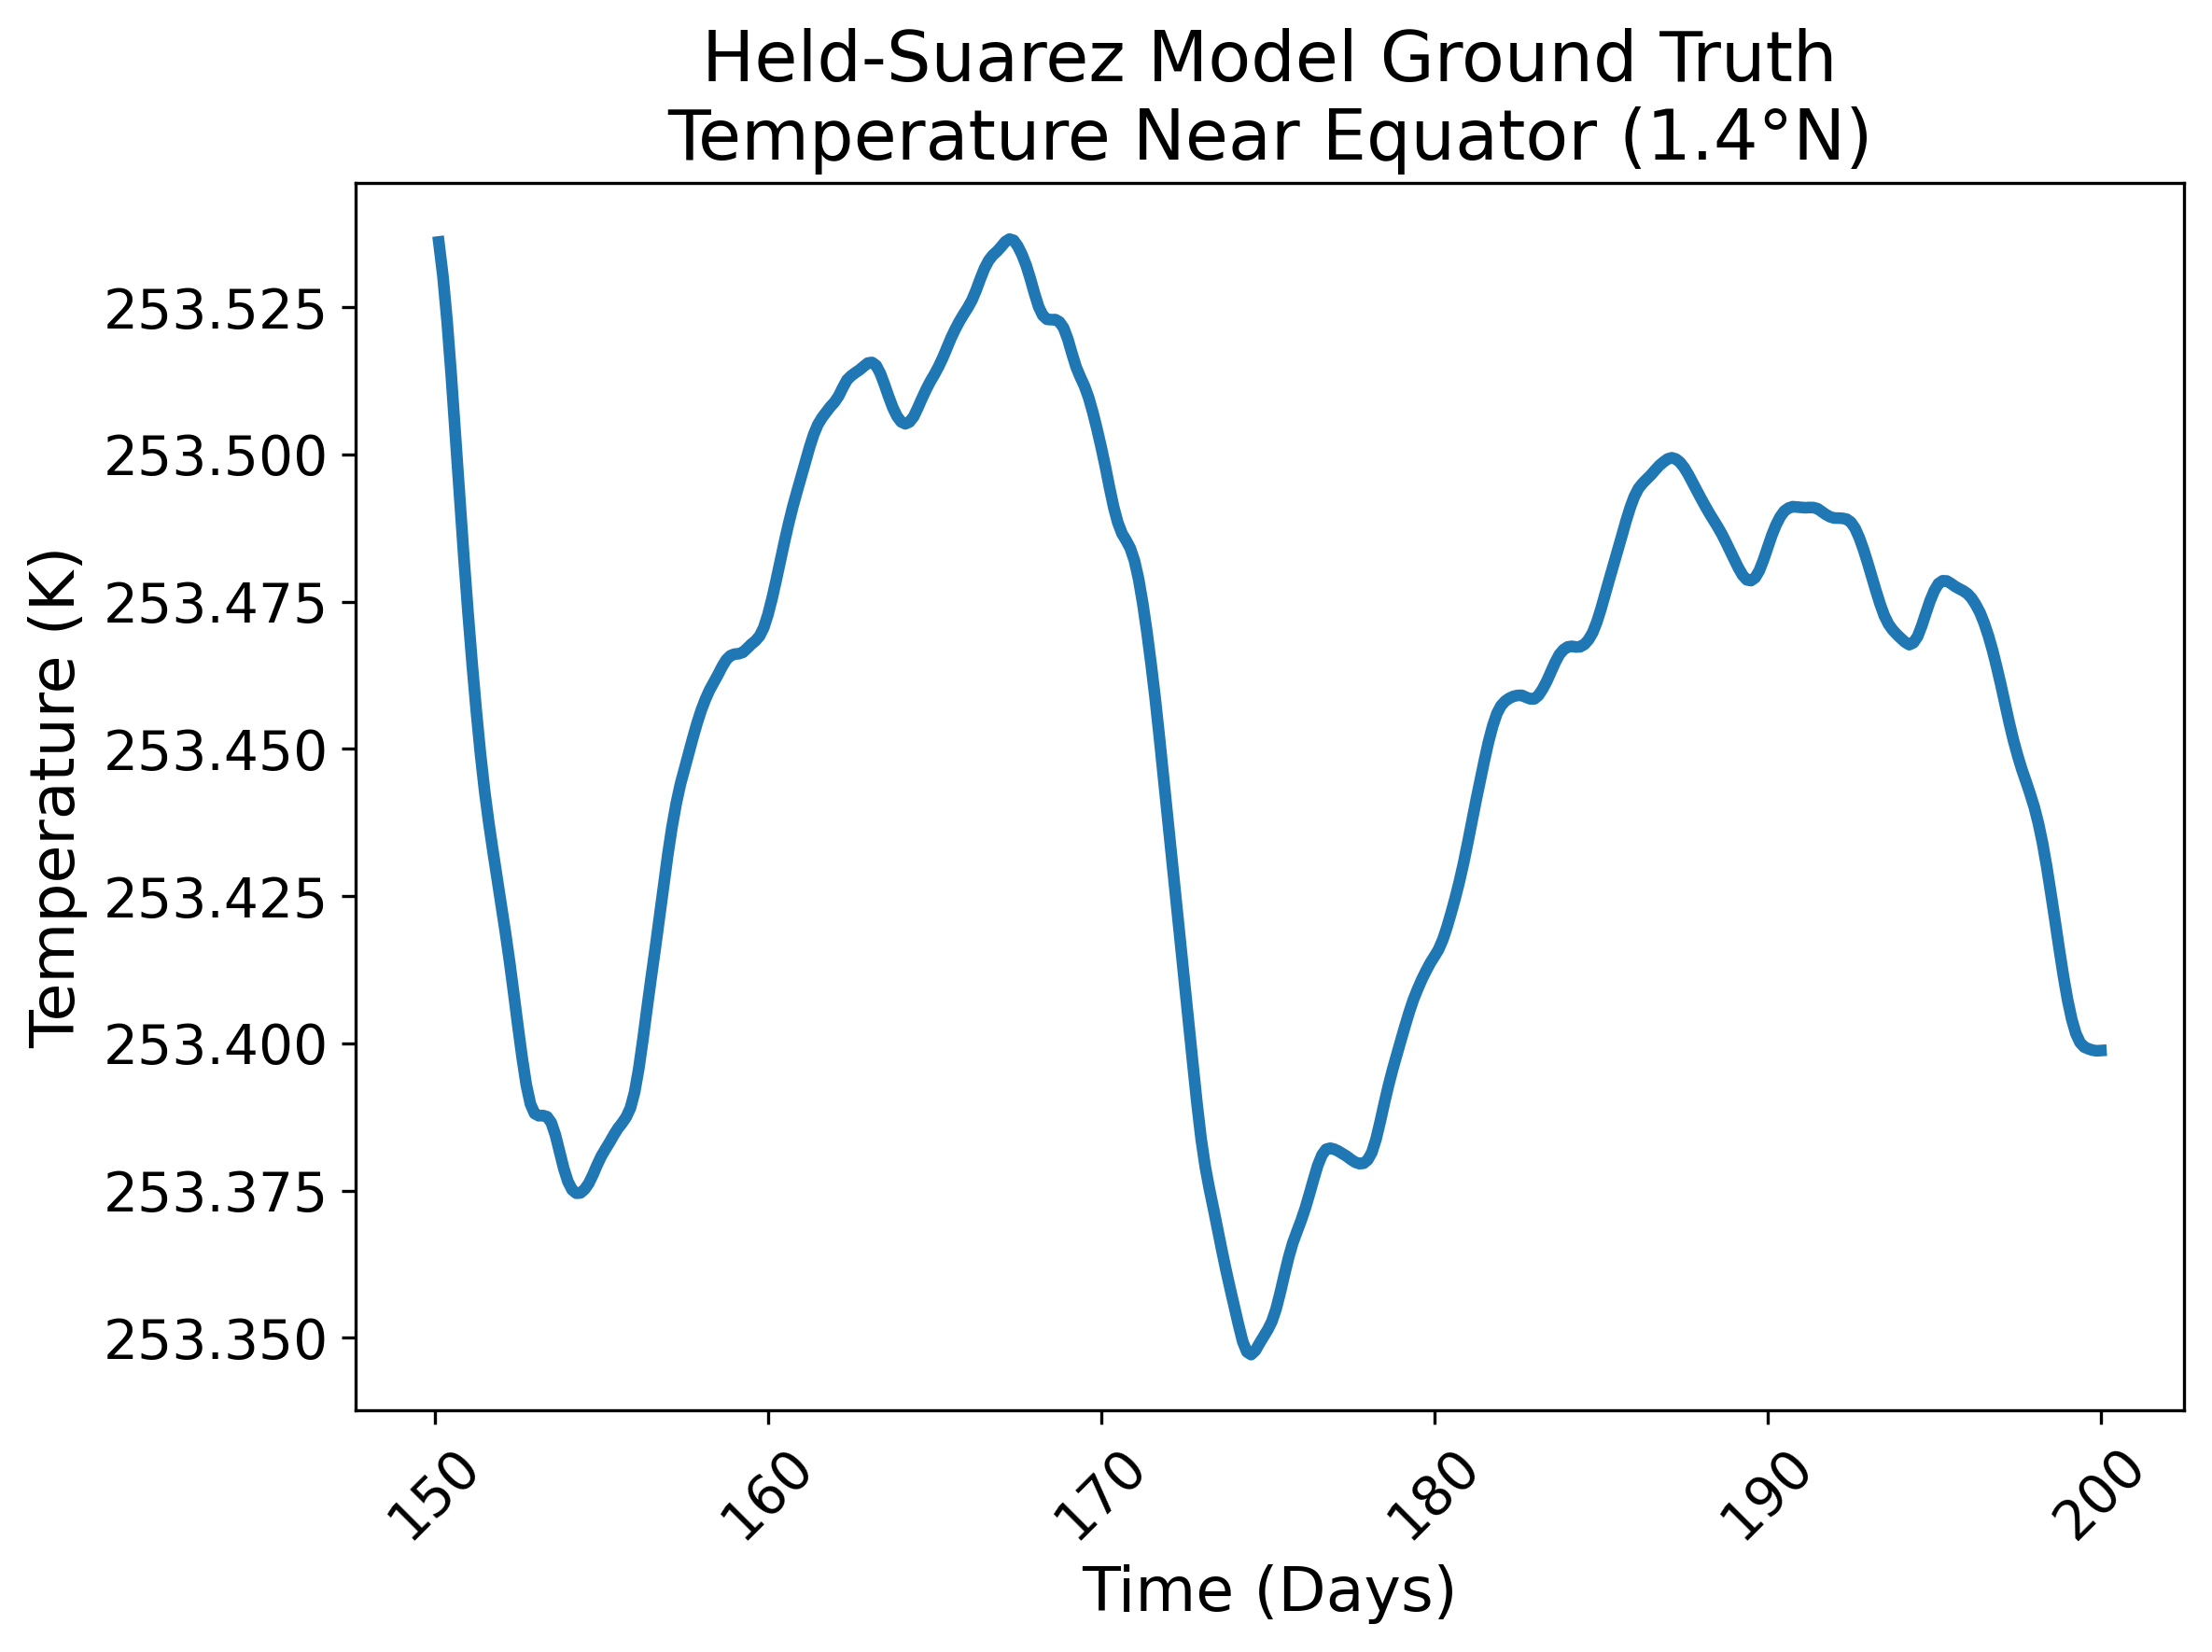

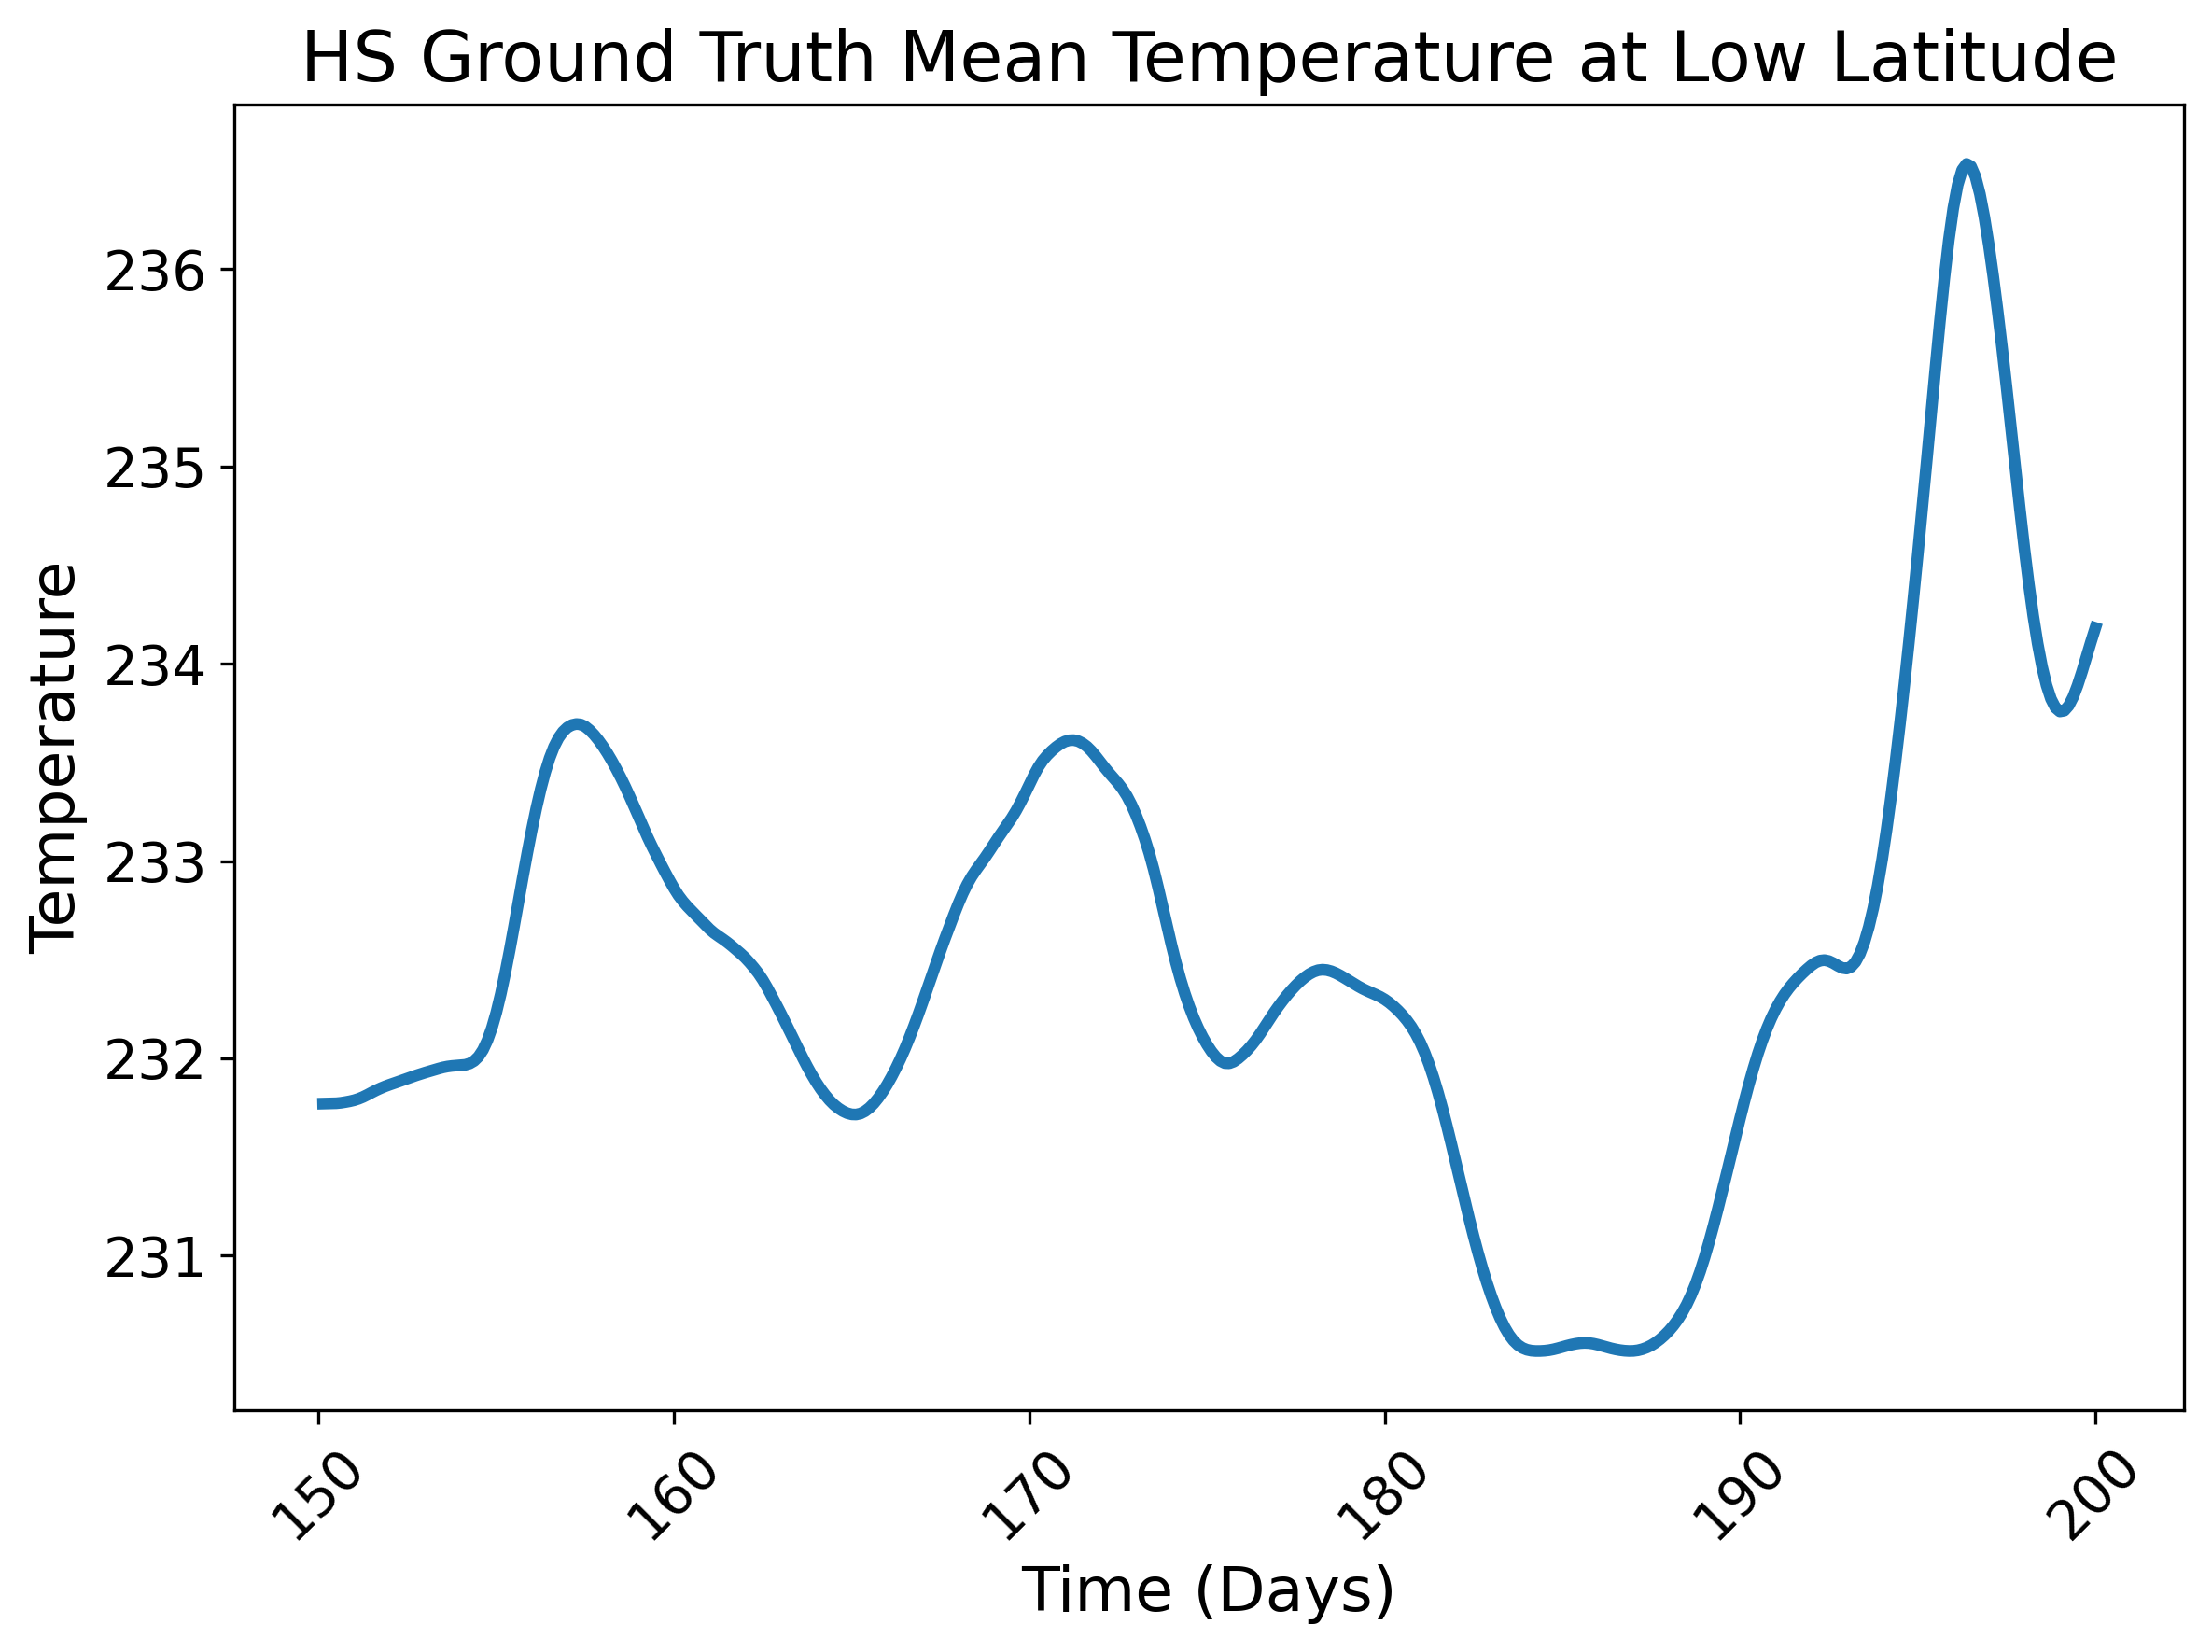

In [7]:
# Lets look at a middle time slice (starting at 150 days and going for 50 days)
start_index = int((150 * 24) / 3)
end_index = start_index + int((50 * 24) / 3)

# plot the temperature data
sns.lineplot(x=time_index[start_index:end_index], y=hs_ground_truth[start_index:end_index, 32])

plt.xlabel("Time (Days)")
plt.ylabel("Temperature (K)")
plt.title("Held-Suarez Model Ground Truth\nTemperature Near Equator (1.4°N)")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()       # Adjust layout to prevent label cutoff
plt.savefig("HS_GT_equator_lat_middle_time.png", dpi=300)
plt.show()

# Do the same for the upper latitude
sns.lineplot(x=time_index[start_index:end_index], y=hs_ground_truth[start_index:end_index, 0])

plt.xlabel("Time (Days)")
plt.ylabel("Temperature")
plt.title("HS Ground Truth Mean Temperature at Low Latitude")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()       # Adjust layout to prevent label cutoff
plt.show()

In [59]:
# Take non-averaged temperature data
# Shape [time, lev, lat, lon]
def apply_noise(data, noise_level):
    # for every value in the data, apply noise scaled by noise level and magnitude of data
    # y_noisy = y + noise_level * y * N(0, 1)
    data_noisy = data.copy()
    noise_matrix = noise_level * data[:, :, :, :] * np.random.normal(0, 1, data[:, :, :, :].shape)
    data_noisy[:, :, :, :] = data[:, :, :, :] + noise_matrix

    # Average over longitude and vertical level
    data_noisy = data_noisy.mean(dim="lon").mean(dim="lev")
    return data_noisy, noise_matrix


In [63]:
noise_levels = [0.0, 0.01, 0.05, 0.1]

# for each noise level, apply noise to the temperature data
noisy_ground_truths = []

for noise_level in noise_levels:
    noisy_ground_truth, _ = apply_noise(hs_ground_truth_nc.T, noise_level)
    noisy_ground_truths.append(noisy_ground_truth)


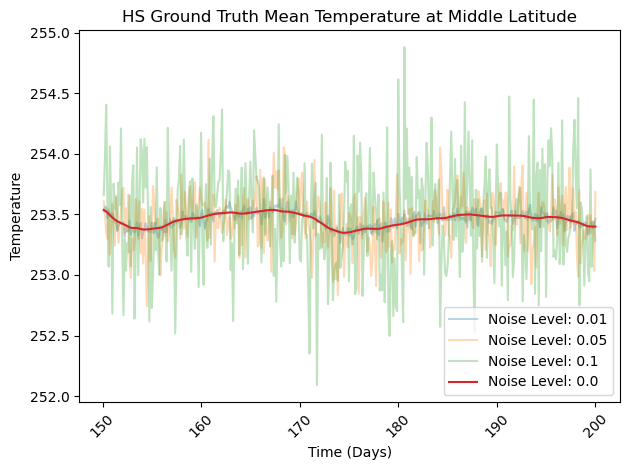

In [64]:
# Plot the temperature data for each noise level
level = 32
for i in range(len(noisy_ground_truths)):
    if i == 0:
        continue
    else:
        sns.lineplot(x=time_index[start_index:end_index], y=noisy_ground_truths[i][start_index:end_index, level], label=f"Noise Level: {noise_levels[i]}", alpha=0.3)

sns.lineplot(x=time_index[start_index:end_index], y=noisy_ground_truths[0][start_index:end_index, level], label=f"Noise Level: {noise_levels[0]}")

plt.xlabel("Time (Days)")
plt.ylabel("Temperature")
plt.title("HS Ground Truth Mean Temperature at Equator")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()       # Adjust layout to prevent label cutoff
plt.legend()
plt.show()



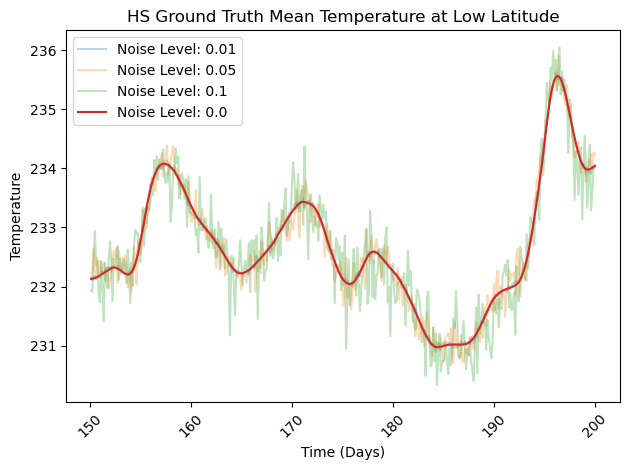

In [67]:
# Plot the temperature data for each noise level
level = 1
for i in range(len(noisy_ground_truths)):
    if i == 0:
        continue
    else:
        sns.lineplot(x=time_index[start_index:end_index], y=noisy_ground_truths[i][start_index:end_index, level], label=f"Noise Level: {noise_levels[i]}", alpha=0.3)

sns.lineplot(x=time_index[start_index:end_index], y=noisy_ground_truths[0][start_index:end_index, level], label=f"Noise Level: {noise_levels[0]}")

plt.xlabel("Time (Days)")
plt.ylabel("Temperature")
plt.title("HS Ground Truth Mean Temperature at Low Latitude")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()       # Adjust layout to prevent label cutoff
plt.legend()
plt.show()

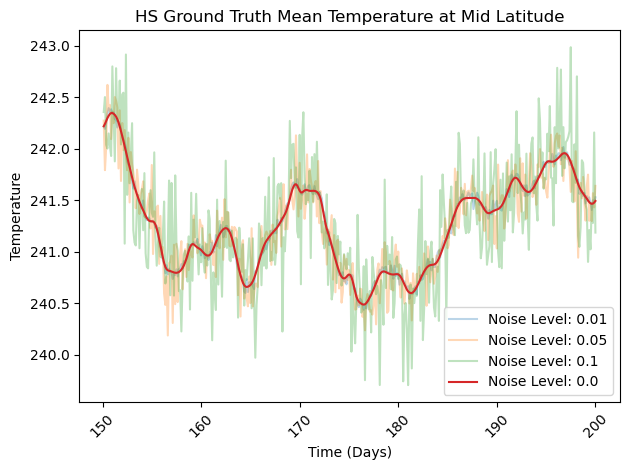

In [68]:
# Plot the temperature data for each noise level
level = 15
for i in range(len(noisy_ground_truths)):
    if i == 0:
        continue
    else:
        sns.lineplot(x=time_index[start_index:end_index], y=noisy_ground_truths[i][start_index:end_index, level], label=f"Noise Level: {noise_levels[i]}", alpha=0.3)

sns.lineplot(x=time_index[start_index:end_index], y=noisy_ground_truths[0][start_index:end_index, level], label=f"Noise Level: {noise_levels[0]}")

plt.xlabel("Time (Days)")
plt.ylabel("Temperature")
plt.title("HS Ground Truth Mean Temperature at Mid Latitude")
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()       # Adjust layout to prevent label cutoff
plt.legend()
plt.show()

In [20]:
test_filename_600 = "My Mac (Teo's MacBook)/Downloads/hs_uki_case_1_1.cam.h1i.0001-01-01-10800.nc"
test_hs = xr.open_dataset(test_filename_600)
test_hs.t.mean(dim="lon").mean(dim="lev").mean(dim="time")

<xarray.Dataset>
Dimensions:  (lat: 64, ilev: 31)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * ilev     (ilev) float64 0.01 33.33 66.67 100.0 ... 900.0 933.3 966.7 1e+03
Data variables: (12/28)
    ntrk     float64 42.0
    ntrn     float64 42.0
    ntrm     float64 42.0
    gw       (lat) float64 0.001783 0.004147 0.006504 ... 0.004147 0.001783
    hyam     float64 1.667e-07
    hybm     float64 0.5
    ...       ...
    f12vmr   float64 -1.0
    sol_tsi  float64 -1.0
    nsteph   float64 2.16e+04
    T        (lat) float32 241.5 241.6 241.9 242.2 ... 242.1 241.7 241.5 241.4
    U        (lat) float32 0.3198 0.7571 1.185 1.558 ... 1.176 0.7736 0.3433
    V        (lat) float32 -0.0004387 -0.001068 -0.001831 ... 0.000853 0.0003335

In [22]:
test_hs.T.mean(dim="lon").mean(dim="lev").mean(dim="time")

<xarray.DataArray 'T' (lat: 64)>
array([241.51784, 241.64346, 241.8645 , 242.18053, 242.57529, 243.03876,
       243.5601 , 244.13641, 244.76477, 245.442  , 246.16547, 246.92873,
       247.7344 , 248.5842 , 249.48193, 250.43065, 251.4219 , 252.4431 ,
       253.47856, 254.50862, 255.51945, 256.50348, 257.46027, 258.3776 ,
       259.2414 , 260.0064 , 260.61804, 261.0603 , 261.33752, 261.4996 ,
       261.57233, 261.6136 , 261.61334, 261.57205, 261.50046, 261.33408,
       261.05856, 260.61758, 260.00223, 259.24084, 258.37384, 257.45428,
       256.5034 , 255.52562, 254.52927, 253.51474, 252.49072, 251.46935,
       250.46713, 249.50368, 248.59254, 247.73415, 246.92117, 246.13937,
       245.38531, 244.67177, 244.01416, 243.42787, 242.90898, 242.45059,
       242.05782, 241.74281, 241.51744, 241.38599], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86

In [9]:
# Plot Spatially
# Read in ground truth held suarez data
# hs_ground_truth_filepath = "HS_ground_truth.cam.h1i.0001-01-01-10800.nc"
hs_ground_truth_filepath = "/Users/teopb/Dropbox/My Mac (Teo's MacBook)/Downloads/HS_GT_600day.cam.h1i.0001-01-01-10800.nc"

hs_ground_truth_nc = xr.open_dataset(hs_ground_truth_filepath)

In [87]:
lats = hs_ground_truth_nc.T.lat.values
lons = hs_ground_truth_nc.T.lon.values
temp_means = hs_ground_truth_nc.T.isel(time=(8 * 200), lev=20)

In [29]:
hs_ground_truth_nc.T

<xarray.DataArray 'T' (time: 4800, lev: 30, lat: 64, lon: 128)>
array([[[[249.82628, ..., 249.82626],
         ...,
         [249.82574, ..., 249.82574]],

        ...,

        [[250.01648, ..., 250.01646],
         ...,
         [250.0164 , ..., 250.0164 ]]],


       ...,


       [[[202.5615 , ..., 202.5588 ],
         ...,
         [203.21382, ..., 203.22342]],

        ...,

        [[262.57993, ..., 262.58875],
         ...,
         [263.64325, ..., 263.64557]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 16.67 50.0 83.33 116.7 ... 883.3 916.7 950.0 983.3
  * time     (time) object 0001-01-01 03:00:00 ... 0002-08-24 00:00:00
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: point

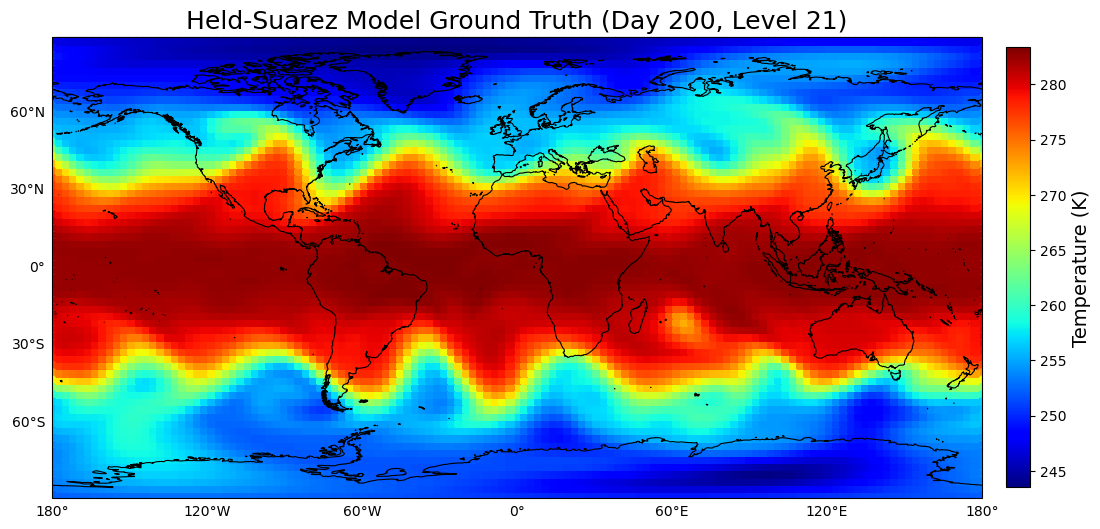

In [88]:
# Create the figure and axis with a specific projection
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and other features
ax.coastlines(resolution='50m', linewidth=0.8)

ax.gridlines(draw_labels=["bottom", "left"], linewidth=0)

cmap = plt.cm.jet
norm = Normalize(vmin=np.nanmin(temp_means), vmax=np.nanmax(temp_means))

# Use xarray's built-in pcolormesh
plot = temp_means.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    add_colorbar=False,
    edgecolor='face',
    add_labels=True
#     cbar_kwargs={'label': 'Kelvin'}
)

ax.set_title("Held-Suarez Model Ground Truth (Day 200, Level 21)", fontsize=18)

# Add custom colorbar
cbar_ax = fig.add_axes([0.92, 0.22, 0.02, 0.55])
cbar = fig.colorbar(plot, cax=cbar_ax)
cbar.set_label('Temperature (K)', fontsize=14)

plt.savefig("HS_GT_plot.png", dpi=300)
plt.show()

In [13]:
lons

array([  0.    ,   2.8125,   5.625 ,   8.4375,  11.25  ,  14.0625,
        16.875 ,  19.6875,  22.5   ,  25.3125,  28.125 ,  30.9375,
        33.75  ,  36.5625,  39.375 ,  42.1875,  45.    ,  47.8125,
        50.625 ,  53.4375,  56.25  ,  59.0625,  61.875 ,  64.6875,
        67.5   ,  70.3125,  73.125 ,  75.9375,  78.75  ,  81.5625,
        84.375 ,  87.1875,  90.    ,  92.8125,  95.625 ,  98.4375,
       101.25  , 104.0625, 106.875 , 109.6875, 112.5   , 115.3125,
       118.125 , 120.9375, 123.75  , 126.5625, 129.375 , 132.1875,
       135.    , 137.8125, 140.625 , 143.4375, 146.25  , 149.0625,
       151.875 , 154.6875, 157.5   , 160.3125, 163.125 , 165.9375,
       168.75  , 171.5625, 174.375 , 177.1875, 180.    , 182.8125,
       185.625 , 188.4375, 191.25  , 194.0625, 196.875 , 199.6875,
       202.5   , 205.3125, 208.125 , 210.9375, 213.75  , 216.5625,
       219.375 , 222.1875, 225.    , 227.8125, 230.625 , 233.4375,
       236.25  , 239.0625, 241.875 , 244.6875, 247.5   , 250.3

In [11]:
temp_means_avg = hs_ground_truth_nc.T.isel(time=slice(1600, None)).mean(dim=["time", "lon"])

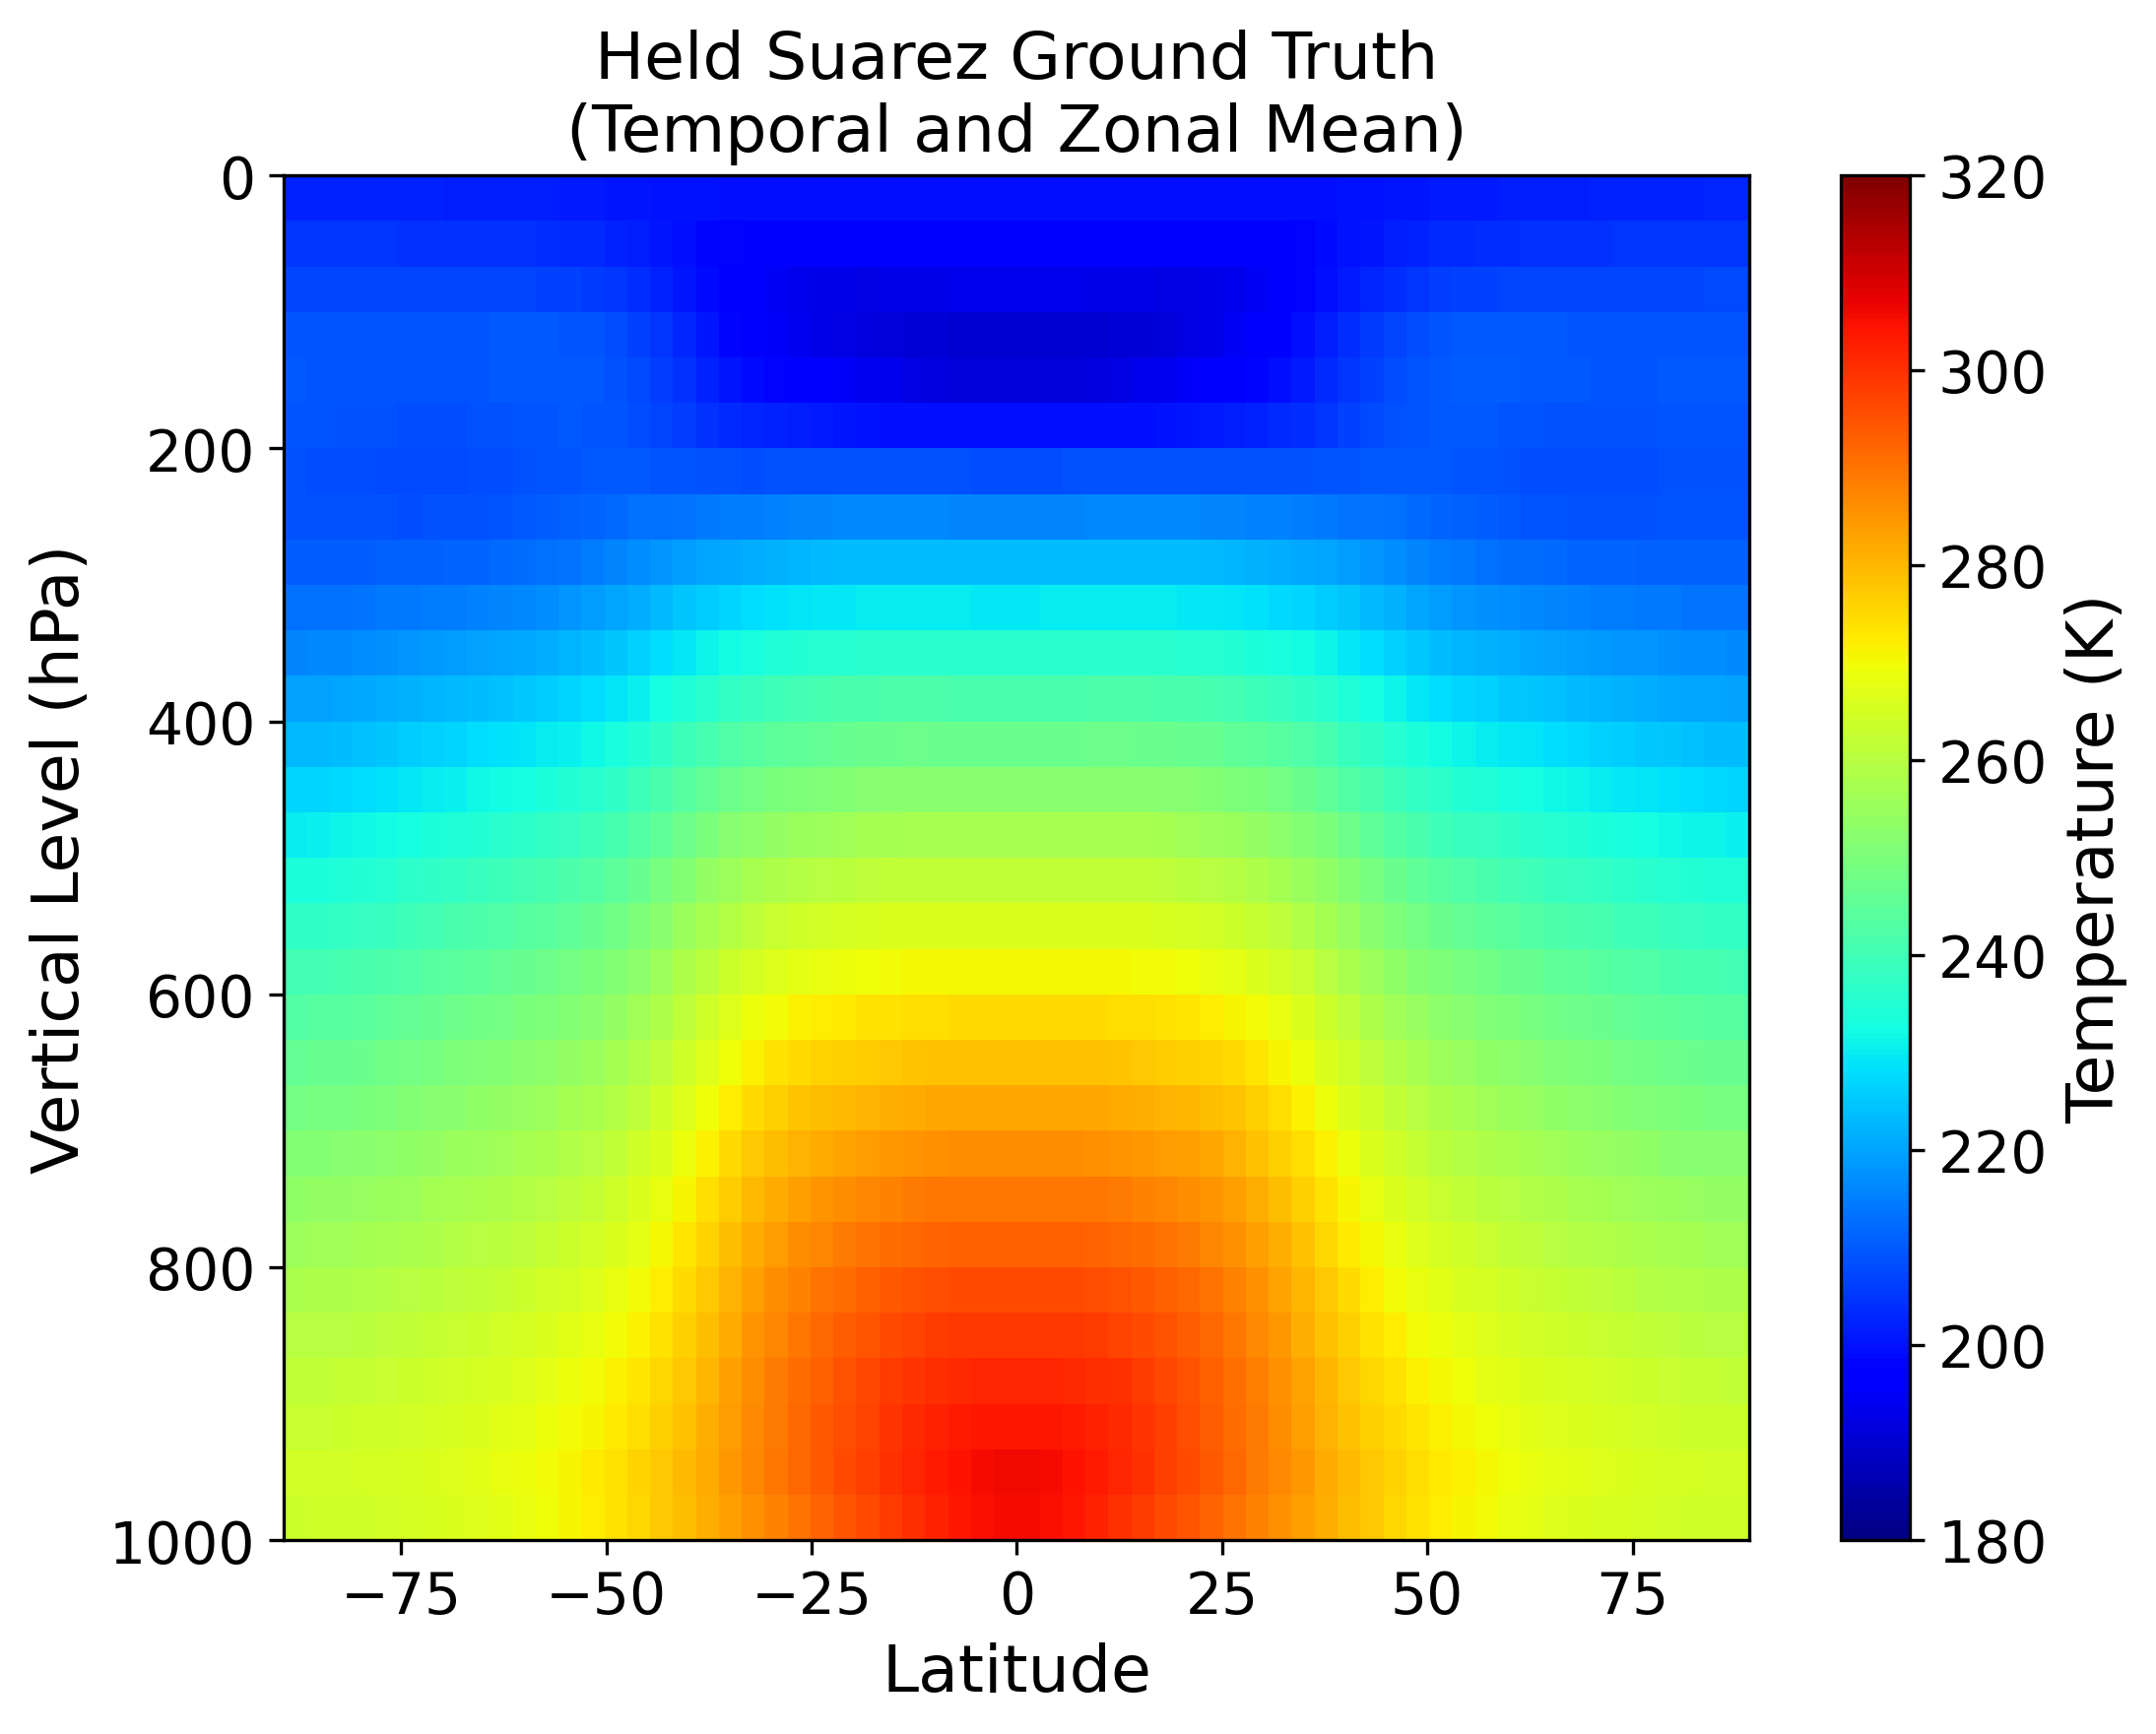

In [12]:
plt.close()

fig, ax = plt.subplots()

# set min and max to scale the plot
vmin = 180
vmax = 320

# set cmap to match HS_GT_plot.png
cmap = plt.cm.jet

temp_means_avg.plot(
    cmap=cmap, 
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={'label': "Temperature (K)"})

ax.set_ylim(1000, 0)
ax.set_ylabel('Vertical Level (hPa)')
ax.set_xlabel('Latitude')
ax.set_title("Held Suarez Ground Truth\n(Temporal and Zonal Mean)", fontsize=16)

plt.savefig("HS_GT_averaged_plot.png", dpi=300)
plt.show()

In [15]:
# Plot Spatially
# Read in held suarez data using prior theta values
hs_prior_filepath = "HS_prior_600day.cam.h1i.0001-01-01-10800.nc"

hs_prior_nc = xr.open_dataset(hs_prior_filepath)

In [16]:
temp_prior_means_avg = hs_prior_nc.T.isel(time=slice(1600, None)).mean(dim=["time", "lon"])

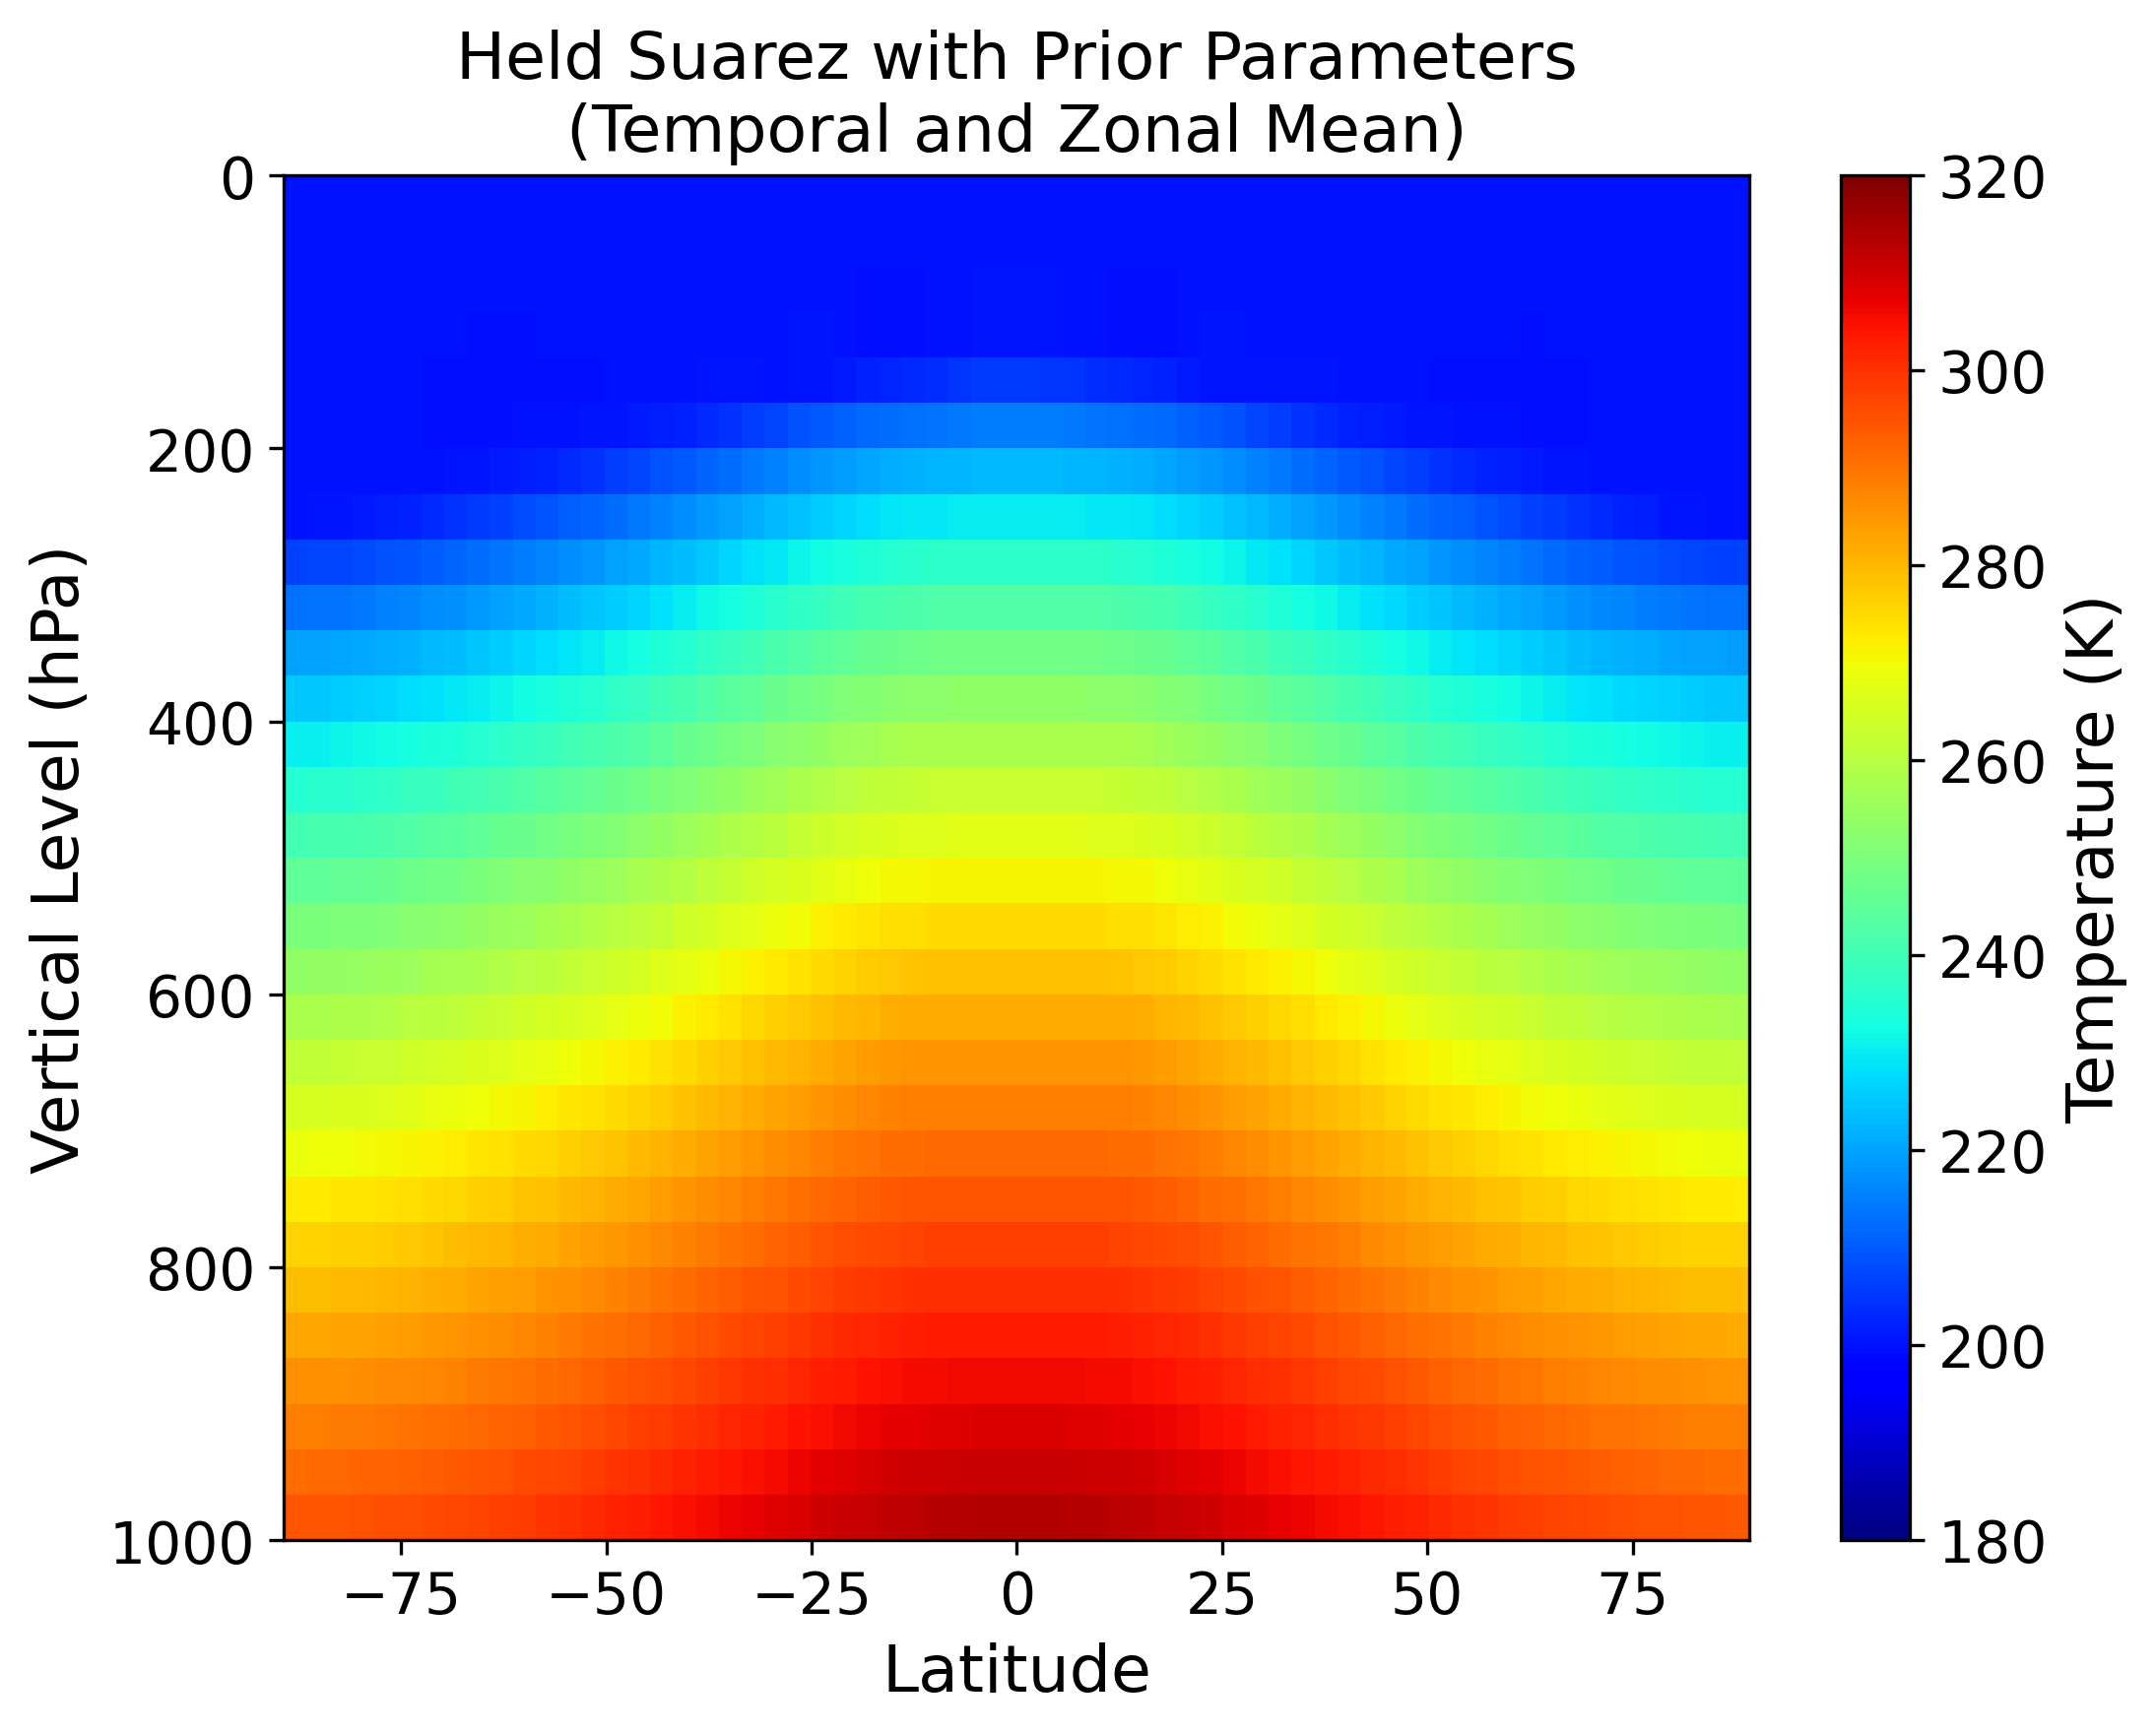

In [17]:
# Need to match colorbar to HS_GT_averaged_plot.png
# set min and max to scale the plot
vmin = 180
vmax = 320

plt.close()

fig, ax = plt.subplots()

cmap = plt.cm.jet

temp_prior_means_avg.plot(
    cmap=cmap, 
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={'label': "Temperature (K)"})

ax.set_ylim(1000, 0)
ax.set_ylabel('Vertical Level (hPa)')
ax.set_xlabel('Latitude')
ax.set_title("Held Suarez with Prior Parameters\n(Temporal and Zonal Mean)", fontsize=16)

plt.savefig("HS_prior_averaged_plot.png", dpi=300)
plt.show()